# NeurIPS Open Polymer Prediction 2025 – Exploratory Data Analysis & Model Evaluation

This notebook performs exploratory data analysis (EDA) and builds predictive models for the NeurIPS Open Polymer Prediction 2025 competition. We load the provided dataset (train.csv) and compute cheminformatics features using RDKit. We then train RandomForest regression models for each target property.

*Targets:* Tg, FFV, Tc, Density, Rg

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import ConvertToNumpyArray
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import zipfile
import math
import pickle
import os

# Helper to compute Morgan fingerprint
def smiles_to_morgan_fp(smiles: str, radius: int = 2, n_bits: int = 2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(n_bits, dtype=int)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    ConvertToNumpyArray(fp, arr)
    return arr

# Helper to compute heavy atom count
from rdkit.Chem.rdMolDescriptors import CalcNumHeavyAtoms
def heavy_atom_count(smiles: str):
    mol = Chem.MolFromSmiles(smiles)
    return CalcNumHeavyAtoms(mol) if mol is not None else np.nan

In [3]:
# Load dataset
train_df = pd.read_csv('train.csv')

# Compute SMILES length and heavy atom count
train_df['smiles_length'] = train_df['SMILES'].str.len()
train_df['heavy_atoms'] = train_df['SMILES'].apply(heavy_atom_count)

# Display summary statistics for target variables
target_cols = ['Tg','FFV','Tc','Density','Rg']
train_df[target_cols].describe()

,Tg,FFV,Tc,Density,Rg
count,511.000000,7030.000000,737.000000,613.000000,614.000000
mean,96.452314,0.367212,0.256334,0.985484,16.419787
std,111.228279,0.029609,0.089538,0.146189,4.608640
min,-148.029738,0.226992,0.046500,0.748691,9.728355
25%,13.674509,0.349549,0.186000,0.890243,12.540328
50%,74.040183,0.364264,0.236000,0.948193,15.052194
75%,161.147595,0.380790,0.330500,1.062096,20.411067
max,472.250000,0.777097,0.524000,1.840999,34.672906


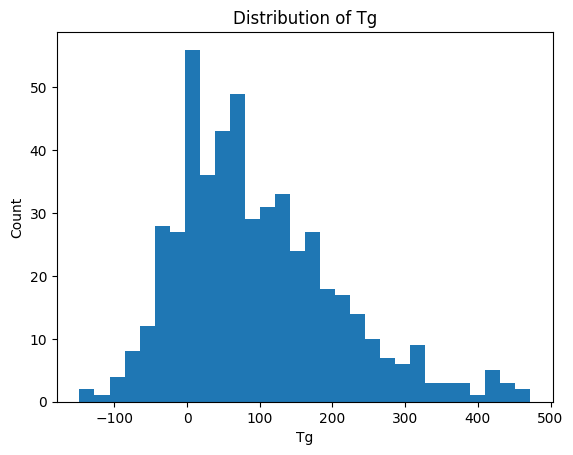

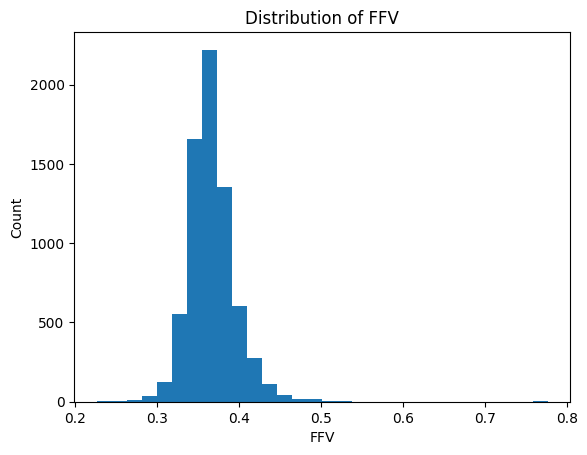

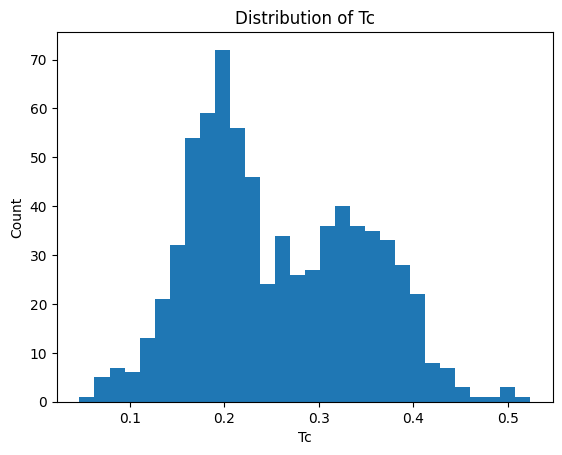

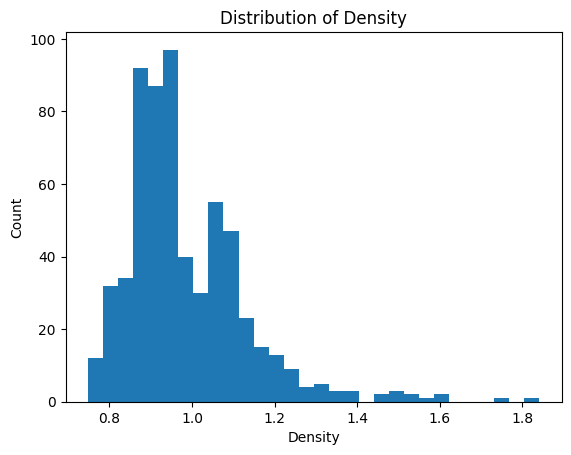

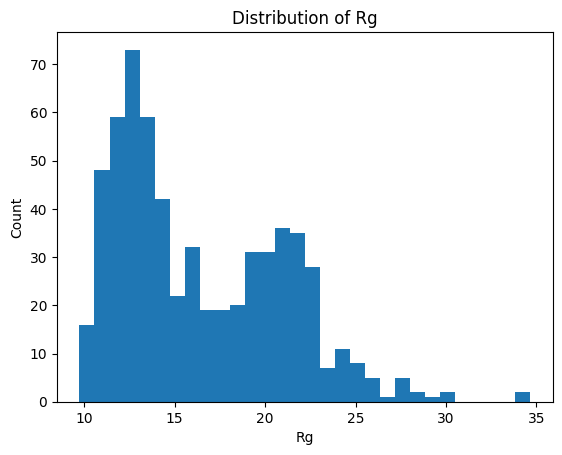

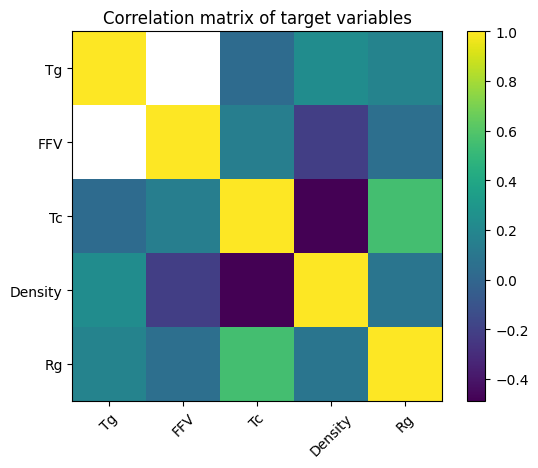

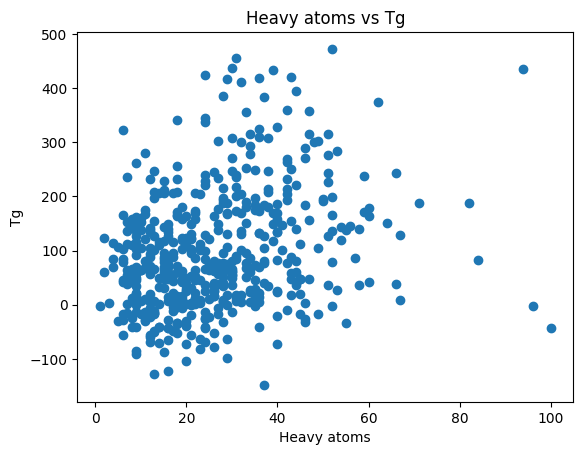

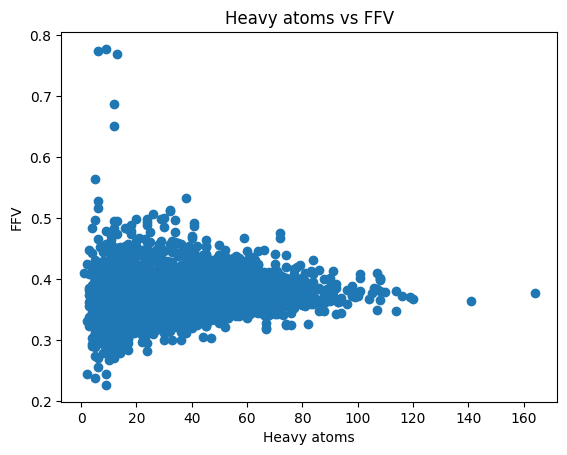

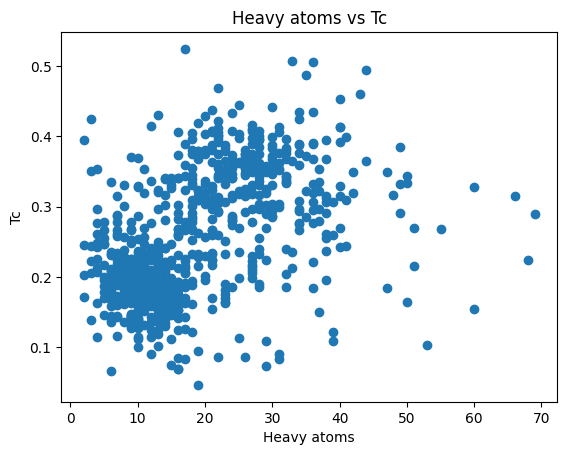

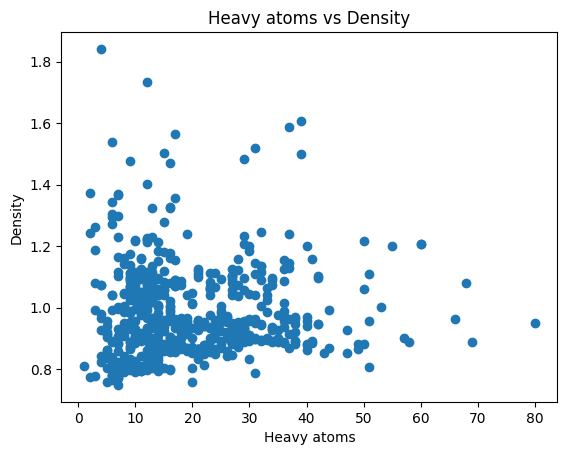

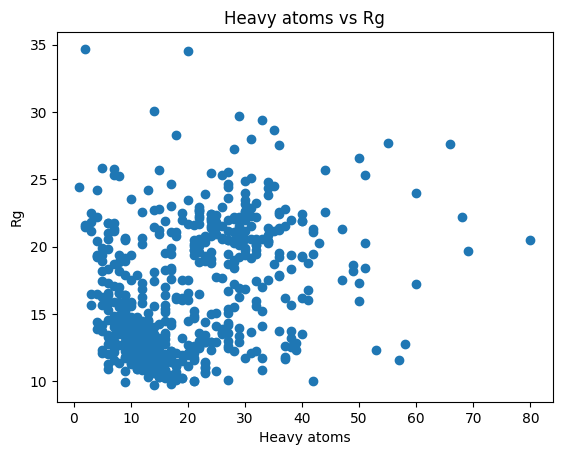

In [4]:
# Visualizations for EDA
for col in target_cols:
    plt.figure()
    plt.hist(train_df[col].dropna(), bins=30)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Distribution of {col}')
    plt.show()

# Correlation matrix among target variables
corr = train_df[target_cols].corr()
plt.figure()
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Correlation matrix of target variables')
plt.show()

# Scatter of heavy atoms vs each target
for col in target_cols:
    plt.figure()
    plt.scatter(train_df['heavy_atoms'], train_df[col])
    plt.xlabel('Heavy atoms')
    plt.ylabel(col)
    plt.title(f'Heavy atoms vs {col}')
    plt.show()

In [5]:
# Compute Morgan fingerprints for all SMILES
X_features = np.array([smiles_to_morgan_fp(s) for s in train_df['SMILES']])
print('Feature matrix shape:', X_features.shape)

[22:58:56] DEPRECATION WARNING: please use MorganGenerator
[22:58:56] DEPRECATION WARNING: please use MorganGenerator
[22:58:56] DEPRECATION WARNING: please use MorganGenerator
[22:58:56] DEPRECATION WARNING: please use MorganGenerator
[22:58:56] DEPRECATION WARNING: please use MorganGenerator
[22:58:56] DEPRECATION WARNING: please use MorganGenerator
[22:58:56] DEPRECATION WARNING: please use MorganGenerator
[22:58:56] DEPRECATION WARNING: please use MorganGenerator
[22:58:56] DEPRECATION WARNING: please use MorganGenerator
[22:58:56] DEPRECATION WARNING: please use MorganGenerator
[22:58:56] DEPRECATION WARNING: please use MorganGenerator
[22:58:56] DEPRECATION WARNING: please use MorganGenerator
[22:58:56] DEPRECATION WARNING: please use MorganGenerator
[22:58:56] DEPRECATION WARNING: please use MorganGenerator
[22:58:56] DEPRECATION WARNING: please use MorganGenerator
[22:58:56] DEPRECATION WARNING: please use MorganGenerator
[22:58:56] DEPRECATION WARNING: please use MorganGenerat

Feature matrix shape: (7973, 2048)


[22:58:59] DEPRECATION WARNING: please use MorganGenerator
[22:58:59] DEPRECATION WARNING: please use MorganGenerator
[22:58:59] DEPRECATION WARNING: please use MorganGenerator
[22:58:59] DEPRECATION WARNING: please use MorganGenerator
[22:58:59] DEPRECATION WARNING: please use MorganGenerator
[22:58:59] DEPRECATION WARNING: please use MorganGenerator
[22:58:59] DEPRECATION WARNING: please use MorganGenerator
[22:58:59] DEPRECATION WARNING: please use MorganGenerator
[22:58:59] DEPRECATION WARNING: please use MorganGenerator
[22:58:59] DEPRECATION WARNING: please use MorganGenerator
[22:58:59] DEPRECATION WARNING: please use MorganGenerator
[22:58:59] DEPRECATION WARNING: please use MorganGenerator
[22:58:59] DEPRECATION WARNING: please use MorganGenerator
[22:58:59] DEPRECATION WARNING: please use MorganGenerator
[22:58:59] DEPRECATION WARNING: please use MorganGenerator
[22:58:59] DEPRECATION WARNING: please use MorganGenerator
[22:58:59] DEPRECATION WARNING: please use MorganGenerat

In [6]:
# Prepare cross-validation and train models
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = {}
metrics = {}

for col in target_cols:
    mask = ~train_df[col].isna()
    X = X_features[mask]
    y = train_df.loc[mask, col].values
    model = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1)
    preds_cv = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)
    mae = mean_absolute_error(y, preds_cv)
    rmse = math.sqrt(mean_squared_error(y, preds_cv))
    metrics[col] = {'MAE': mae, 'RMSE': rmse}
    model.fit(X, y)
    models[col] = model
    print(f'{col}: MAE={mae:.4f}, RMSE={rmse:.4f}')

# Display evaluation metrics
pd.DataFrame(metrics).T

Tg: MAE=54.5530, RMSE=71.4589
FFV: MAE=0.0082, RMSE=0.0159
Tc: MAE=0.0328, RMSE=0.0469
Density: MAE=0.0501, RMSE=0.0866
Rg: MAE=1.6882, RMSE=2.4889


,MAE,RMSE
Tg,54.552955,71.458907
FFV,0.008195,0.015914
Tc,0.032791,0.046858
Density,0.050097,0.086590
Rg,1.688205,2.488931


In [10]:
import os
import pickle


model_dir = "./Trained"
os.makedirs(model_dir, exist_ok=True)

# Save each model individually
for property_name, model_obj in models.items():
    model_path = os.path.join(model_dir, f"{property_name}_rf_model.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(model_obj, f)
    print(f"✅ Saved model for '{property_name}' to: {model_path}")

print(f"\nAll models saved successfully in: {os.path.abspath(model_dir)}")

✅ Saved model for 'Tg' to: ./Trained\Tg_rf_model.pkl
✅ Saved model for 'FFV' to: ./Trained\FFV_rf_model.pkl
✅ Saved model for 'Tc' to: ./Trained\Tc_rf_model.pkl
✅ Saved model for 'Density' to: ./Trained\Density_rf_model.pkl
✅ Saved model for 'Rg' to: ./Trained\Rg_rf_model.pkl

All models saved successfully in: C:\Users\Lakin\Downloads\CIS 6005 Computational Intelligence\2\Dataset\Trained
